<img src="TwitterData/flow.png"/>

### Read the input data files.

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import sklearn.metrics.pairwise as sk
from textblob import TextBlob
#nltk.download()
from nltk.corpus import stopwords
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
#Read the tweets one by one and process it
import csv
user_id=[]
inpTweets = csv.reader(open('TwitterData/survey_dump_with_tweet_count', 'rt',encoding='utf8'), delimiter=',')
i = 0
for row in inpTweets:
    i+=1;
    if(i>1):
        user_id.append(row[0])
    if('1663416536' in row):
        print(i)

print(i);

79
159


### Pre-process Tweets

In [3]:


class PreprocessTweets:

    def __init__(self):
        self.name = 'PreprocessTweets'

    #start process_tweet
    def processTweet(self, tweet):
        
        #Convert to lower case
        tweet = tweet.lower()
        #Convert www.* or https?://* to URL
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
        #Convert @username to AT_USER
        tweet = re.sub('@[^\s]+','AT_USER',tweet)
        #Remove additional white spaces
        tweet = re.sub('[\s]+', ' ', tweet)
        #Replace #word with word
        tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
        #trim
        tweet = tweet.strip('\'"')
        # Remove all Non-ASCII characters
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        return tweet

In [4]:
class FilterStopWords:

    # stopWords = []
    def __init__(self):
        self.name = 'FilterStopWords'
        #initialize stopWords
        self.stopWords = []


    def getStopWordList(self, stopWordListFileName):
        #read the stopwords file and build a list
        stopWords = []
        stopWords.append('AT_USER')
        stopWords.append('URL')
        stopWords.append('[')
        stopWords.append('[')

        fp = open(stopWordListFileName, 'r',encoding='utf8')
        line = fp.readline()
        while line:
            word = line.strip()
            stopWords.append(word)
            line = fp.readline()
        fp.close()
        return stopWords
    
    def getFeatureVector(self, tweet, stopWords):
        featureVector = []
        #split tweet into words
        words = tweet.split()
        for w in words:
            #replace two or more with two occurrences
            #w = replaceTwoOrMore(w)
            #strip punctuation
            w = w.strip('\'"?,.')
            #check if the word stats with an alphabet
            val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", w)
            #ignore if it is a stop word
            if(w in self.stopWords or val is None):
                continue
            else:
                featureVector.append(w.lower())
        return featureVector

### Feature Engineering 

In [5]:
class FeatureEngineering:

    def __init__(self):
        self.name = 'FeatureEngineering'
        self.featureList = []
        # self.sid = SentimentIntensityAnalyzer()

    #start extract_features
    def extract_features(self,tweet):
        tweet_words = set(tweet)
        features = {}
        for word in self.featureList:
            features['contains(%s)' % word] = (word in tweet_words)
        return features

## Create New Training set based on personality labels predicted from Survey results

    def createNewTrainingSet(self, fileName):
        XTrain = []
        YTrain = []
        XTrainFeatures = []
        XTrainSentiment = []
        XTrainFreqTweets = []
        geo_latitude = []
        geo_longitude = []
        
        objFilterStopWords = FilterStopWords()
        objPreprocessTweets = PreprocessTweets()

        stopWords = objFilterStopWords.getStopWordList('TwitterData/StopWords.txt')
        
        #Read the tweets one by one and process it
        inpTweets = csv.reader(open(fileName, 'r',encoding='utf8'), delimiter=',')
        next(inpTweets)
        tweets = []
        i = 0
        for row in inpTweets:
            personality = row[5]
            tweet = row[1]
            cleanTweet = tweet.replace('"",""'," ")
            cleanTweet = cleanTweet.replace('""'," ")
            processedTweet = objPreprocessTweets.processTweet(cleanTweet)

            XTrainFreqTweets.append(int(row[4]))
            wordsList = processedTweet.split()
            
            # Remove stop words
            filtered_words = [word for word in wordsList if word not in stopwords.words('english')]
            filteredTweets = ' '.join(filtered_words)
            
            featureVector = objFilterStopWords.getFeatureVector(processedTweet, stopWords)
            
            geo_latitude.append(float(row[2]))
            geo_longitude.append(float(row[3]))
            
            blob = TextBlob(processedTweet)
            sentiment = 0
            for sentence in blob.sentences:
                sentiment += sentence.sentiment.polarity

            totSentiment = sentiment/ len(blob.sentences)

            XTrainSentiment.append(totSentiment)

            XTrainFeatures.append(filteredTweets)
            
            YTrain.append(personality)       

        return XTrain, YTrain, XTrainFeatures, XTrainSentiment, XTrainFreqTweets, geo_latitude, geo_longitude


In [6]:
objFeatureEngineering = FeatureEngineering()
fileName = 'TwitterData/survey_dump_with_tweet_count'
XTrain, YTrain, XTrainFeatures, XTrainSentiment, XTrainFreqTweets, geo_latitude, geo_longitude = objFeatureEngineering.createNewTrainingSet(fileName)

### Get Feature vector

In [7]:
newYTrain = []

for item in YTrain:
    temp = item.replace('[', '')
    temp = temp.replace('\"', '')
    newItem = temp.replace(']', '')
    newYTrain.append(newItem)
    
YTrain = newYTrain

### Map the class labels to numbers

In [8]:
def mapLabels(className):
    if className == 'Conscientiousness':
        return 0
    elif className == 'Extrovert':
        return 1
    elif className == 'Agreeable':
        return 2
    elif className == 'Empathetic':
        return 3
    elif className == 'Novelty Seeking':
        return 4
    elif className == 'Perfectionist':
        return 5
    elif className == 'Rigid':
        return 6
    elif className == 'Impulsive':
        return 7
    elif className == 'Psychopath':
        return 8
    elif className == 'Obsessive':
        return 9
    #elif className == None:
        #return 10
    else:
        pass

YTrain = [mapLabels(x) for x in YTrain]

In [9]:
XTrain = np.array(XTrainFeatures)
YTrain = np.array(YTrain)

In [10]:
YTrain

array([7, 8, 6, 4, 9, 7, 9, 6, 1, 6, 7, 2, 4, 2, 2, 7, 9, 7, 9, 7, 8, 6,
       9, 4, 8, 9, 1, 3, 9, 9, 8, 7, 7, 9, 9, 1, 1, 1, 8, 9, 7, 8, 1, 6,
       8, 5, 8, 6, 3, 1, 4, 9, 3, 9, 7, 7, 9, 9, 3, 7, 3, 9, 4, 8, 7, 1,
       9, 9, 1, 9, 1, 3, 3, 2, 3, 1, 1, 0, 4, 7, 8, 6, 4, 9, 7, 9, 6, 1,
       6, 7, 2, 4, 2, 2, 7, 9, 7, 9, 7, 8, 6, 9, 4, 8, 9, 1, 3, 9, 9, 8,
       7, 7, 9, 9, 1, 1, 1, 8, 9, 7, 8, 1, 6, 8, 5, 8, 6, 3, 1, 4, 9, 3,
       9, 7, 7, 9, 9, 3, 7, 3, 9, 4, 8, 7, 1, 9, 9, 1, 9, 1, 3, 3, 2, 3,
       1, 1, 0, 4])

### Split Train and Test data

In [11]:
n=60
trainSamples = XTrain[0:n]
YtrainSamples = YTrain[0:n]

testSamples = XTrain[n:]
YtestSamples = YTrain[n:]

trainSentimentSamples = np.array(XTrainSentiment[0:n])
testSentimentSamples = np.array(XTrainSentiment[n:])
trainFreqTweetSamples = np.array(XTrainFreqTweets[0:n])
testFreqTweetSamples = np.array(XTrainFreqTweets[n:])

### Bag of Words as Features

In [12]:

vectorizer = CountVectorizer()
XTr = vectorizer.fit_transform(trainSamples)

trainBagVector = XTr.toarray()
XTe = vectorizer.transform(testSamples)
testBagVector = XTe.toarray()

In [13]:
XEv = XTe

### Stack or concatenate all features together

In [14]:
XTrainWordFeatures = trainBagVector #trainNGramVector

temp = np.column_stack((XTrainWordFeatures, trainSentimentSamples))

XTrainAllFeatures =  np.column_stack((temp, trainFreqTweetSamples))

XTestWordFeatures = testBagVector #testNGramVector
temp =  np.column_stack((XTestWordFeatures, testSentimentSamples))

XTestAllFeatures =  np.column_stack((temp, testFreqTweetSamples))

### Write Predicted Output Labels to File

In [15]:
def writePredictedLabelFile(YPred):
    f = open("Predictions.csv","w")
    f.write("Id,Label" + "\n")
    for i in range(len(YPred)):
        f.write(str(i) + "," + str(np.around(YPred[i],decimals=2))+ "\n")
    f.close()

In [16]:
train = XTrainAllFeatures

YTrain = YtrainSamples
YTest = YtestSamples

In [17]:
from sklearn.neighbors import KNeighborsClassifier

train = XTrainAllFeatures
test = XTestAllFeatures

params = {'neighbours':10}
neighbours = params['neighbours']
neigh = KNeighborsClassifier(n_neighbors=neighbours)
YPredKNN = neigh.fit(train, YTrain).predict(test)

In [18]:
from sklearn.ensemble import RandomForestClassifier
params = {'trees':150, 'criterion':'entropy','random_state':None}
trees = params['trees']
crit = params['criterion']
seed = params['random_state']
clf = RandomForestClassifier(n_estimators=trees,criterion=crit,random_state=seed)
clf.fit(train, YTrain)
YPredRF = clf.predict(test)

In [19]:
#LogReg = linear_model.LogisticRegression(solver = 'sag', multi_class = 'multinomial',penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None)
LogReg = linear_model.LogisticRegression()
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 9)
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(LogReg, hyperparameters)

clf.fit(train, YTrain)
YPredLR = clf.predict(test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [20]:
from sklearn import svm

params = {'kernel':'linear'}
ker = params['kernel']
YPred = svm.SVC(kernel=ker, probability = True).fit(train, YTrain).decision_function(test)

In [21]:
YPred  # [7, 8, 6, 4, 9, 7, 9, 6, 1, 6, 7, 2, 4, 2, 2, 7, 9, 7, 9, 7, 8, 6,
#9, 4, 8, 9, 1, 3, 9, 9, 8, 7, 7, 9, 9, 1, 1, 1, 8, 9, 7, 8, 1, 6,
 #      8, 5, 8, 6, 3, 1, 4, 9, 3, 9, 7, 7, 9, 9, 3, 7, 3, 9, 4, 8, 7, 1,
  #     9, 9, 1, 9, 1, 3, 3, 2, 3, 1, 1, 0, 4, 7, 8, 6, 4, 9, 7, 9, 6, 1,
   #    6, 7, 2, 4, 2, 2, 7, 9, 7, 9, 7, 8, 6, 9, 4, 8, 9, 1, 3, 9, 9, 8,
    #   7, 7, 9,9,
     #  1, 1, 1, 8, 9, 7, 8, 1, 6, 8,5, 8,
      # 6, 3, 1, 4, 9, 3, 9, 7, 7, 9, 9, 3, 7, 3, 9, 4, 8, 7, 1, 9, 9, 1, 
       #9, 1, 3, 3, 2, 3, 1, 1, 0, 4]'''

array([[ 4.01325429,  0.77695734,  6.0674865 ,  3.9835654 , -0.23168918,
         2.93236488,  3.01232   ,  7.13202333,  8.31371744],
       [ 6.13183706,  0.81675151,  5.07833974,  4.00053952, -0.22092221,
         2.87367556,  1.89559125,  7.14419787,  8.27998969],
       [ 2.96837984,  0.93486432,  2.97518037,  5.05897008, -0.23217375,
         2.97211292,  8.18894642,  7.08716709,  6.04655271],
       [ 6.06135166,  0.93795652,  1.84320315,  6.1379051 , -0.16716529,
         6.11152866,  5.01676441,  5.03175719,  5.0266986 ],
       [ 5.06056447,  0.91616568,  1.88575319,  6.1055872 , -0.19223839,
         7.09898615,  6.05554698,  2.99199941,  6.07763531],
       [ 0.93290096,  1.95745194,  3.98193766,  5.03361923, -0.24636243,
         2.97232943,  8.2152489 ,  7.12291546,  6.02995885],
       [ 2.85463119,  0.80819865,  8.25173422,  3.98916399, -0.26995757,
         1.75828179,  7.28613325,  5.17982759,  6.14198691],
       [ 4.01550446,  0.71668019,  7.20958491,  4.05302676, -0

In [22]:
dfYPred=YPred

In [23]:
df=pd.DataFrame(data=dfYPred)

In [24]:
dfYPred

array([[ 4.01325429,  0.77695734,  6.0674865 ,  3.9835654 , -0.23168918,
         2.93236488,  3.01232   ,  7.13202333,  8.31371744],
       [ 6.13183706,  0.81675151,  5.07833974,  4.00053952, -0.22092221,
         2.87367556,  1.89559125,  7.14419787,  8.27998969],
       [ 2.96837984,  0.93486432,  2.97518037,  5.05897008, -0.23217375,
         2.97211292,  8.18894642,  7.08716709,  6.04655271],
       [ 6.06135166,  0.93795652,  1.84320315,  6.1379051 , -0.16716529,
         6.11152866,  5.01676441,  5.03175719,  5.0266986 ],
       [ 5.06056447,  0.91616568,  1.88575319,  6.1055872 , -0.19223839,
         7.09898615,  6.05554698,  2.99199941,  6.07763531],
       [ 0.93290096,  1.95745194,  3.98193766,  5.03361923, -0.24636243,
         2.97232943,  8.2152489 ,  7.12291546,  6.02995885],
       [ 2.85463119,  0.80819865,  8.25173422,  3.98916399, -0.26995757,
         1.75828179,  7.28613325,  5.17982759,  6.14198691],
       [ 4.01550446,  0.71668019,  7.20958491,  4.05302676, -0

In [25]:
pers=['Conscientiousness','Extrovert','Agreeable','Emphathetic','Nov Seekng','Perfectionist','Rigid','Impulsive','Psychopath','Obsessive']

In [26]:
df.columns=pers

ValueError: Length mismatch: Expected axis has 9 elements, new values have 10 elements

In [27]:
df['dom_pers']=df.idxmax(axis=1)

In [28]:
df['thres']= np.random.randint(10, 100, df.shape[0])

In [29]:
df['user_id']=user_id[n:]

In [30]:
df.set_index('user_id')
df.head(10)

,0,1,2,3,4,5,6,7,8,dom_pers,thres,user_id
0,4.013254,0.776957,6.067487,3.983565,-0.231689,2.932365,3.012320,7.132023,8.313717,8,83,1414166594
1,6.131837,0.816752,5.078340,4.000540,-0.220922,2.873676,1.895591,7.144198,8.279990,8,14,1438909568
2,2.968380,0.934864,2.975180,5.058970,-0.232174,2.972113,8.188946,7.087167,6.046553,6,83,1516255956
3,6.061352,0.937957,1.843203,6.137905,-0.167165,6.111529,5.016764,5.031757,5.026699,3,17,1530948307
4,5.060564,0.916166,1.885753,6.105587,-0.192238,7.098986,6.055547,2.991999,6.077635,5,56,1534856329
5,0.932901,1.957452,3.981938,5.033619,-0.246362,2.972329,8.215249,7.122915,6.029959,6,13,1537350764
6,2.854631,0.808199,8.251734,3.989164,-0.269958,1.758282,7.286133,5.179828,6.141987,2,74,1537352881
7,4.015504,0.716680,7.209585,4.053027,-0.238177,1.824197,4.997445,5.088841,8.332898,8,14,1601780840
8,4.030766,0.855116,1.923461,5.064130,-0.224890,3.017317,8.108402,6.085843,7.139856,6,81,1607302296
9,4.067897,0.637629,8.500000,6.219106,-0.252399,1.709356,2.787941,7.324465,5.006003,2,88,1620048930


In [31]:
def cosine_sim(df):
    for index, row in df.iterrows():
        print((row[1:9]))

In [32]:
df1=pd.DataFrame(data=sk.cosine_similarity(YPred,YPred))

In [33]:
df1=df1*100

In [34]:
df1.columns=user_id[n:]
df1['user_id']=user_id[n:]

In [35]:
#df_1=df1.loc[df1['user_id'] == '1516255956']

In [36]:
#userid or input
userid='1414166594'

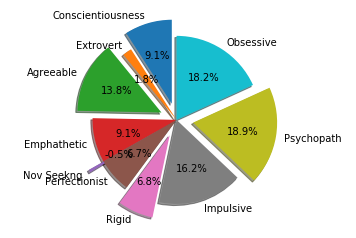

In [37]:
df_d=df.loc[df['user_id'] == userid]

labels = tuple(pers)#'Extrovert', 'Agreeable', 'Empathetic','Novelty Seeking','Perfectionist','Rigid','Impulsive','Psychopath','Obsessive'
sizes = df_d.iloc[0,:10]

explode = (0.2,0,0.2,0,0.2,0,0.2,0,0.2,0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [38]:
df_d=df1.loc[df1['user_id'] == userid]
df_2=df_d[(df_d<100) & (df_d>df.loc[df['user_id'] == userid]['thres'].iloc[0])]
df_2=df_2[df_2!='NaN']
df_2.dropna(axis=1,inplace=True)
df_2=df_2.iloc[:,:-1]
df_2=df_2.transpose()
df_2.columns=[1]
df_2=df_2.sort_values(1)

In [39]:
df_2.head()

,1
1238463202,83.001573
1632372234,83.001573
1478136910,83.165662
1649744274,83.165662
1152987452,83.721876


In [40]:
from IPython import display
def plotSimilarityGraph(userid2):
    
    user_personality_df=df.loc[(df['user_id'] == userid) | (df['user_id']==userid2 )]

    del user_personality_df['thres']
    del user_personality_df['dom_pers']

    df_melt = user_personality_df.melt('user_id', var_name='Personalities',  value_name='Magnitudes')
    df_melt

    barG=sns.factorplot(data=df_melt, kind='bar',hue='user_id',x='Personalities',y='Magnitudes',palette='Set1')
    barG.set_xticklabels(rotation=90)
    display.display(barG)

Do you want another suggestion? (y/n): n


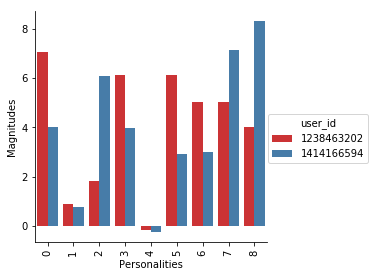

In [41]:
for index,row in df_2.itertuples():
    plotSimilarityGraph(index)
    inp=input("Do you want another suggestion? (y/n): ")
    if(inp=='n'):
        break;